In [49]:
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import Optional, Any
from collections import deque
from matplotlib import pyplot as plt
from queue import PriorityQueue
from datetime import datetime

Вводим датаклассы

In [50]:
@dataclass(order=True)
class PrioritizedItem:
    priority: float
    item: Any=field(compare=False)
        
        
@dataclass
class Order:  # Our own placed order
    timestamp: float
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    timestamp: float
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float

        

@dataclass
class AnonTrade:  # Market trade
    exchange_ts: float
    receive_ts: float
    side: str
    size: float
    price: float


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    exchange_ts: float
    receive_ts: float
    asks: list[tuple[float, float]]  # tuple[price, size]
    bids: list[tuple[float, float]]


@dataclass
class MdUpdate:  # Data of a tick
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trades: Optional[AnonTrade] = None

Вспомогательная функция-маппер для переименования имен колонок:

In [4]:
def rename_columns(x):
    if x.startswith('btcusdt:Binance:LinearPerpetual_') or x.startswith('ethusdt:Binance:LinearPerpetual_'):
        return x[len('btcusdt:Binance:LinearPerpetual_'):]
    else:
        return x

Функция, которая i-строку датафрейма превращает в объект OrderbookSnapshotUpdate:

In [5]:
def get_orderbook(dframe, i):
    asks = []
    bids = []
    for k in range(10):
        asks.append((dframe.loc[i, f'ask_price_{k}'], dframe.loc[i, f'ask_vol_{k}']))
        bids.append((dframe.loc[i, f'bid_price_{k}'], dframe.loc[i, f'bid_vol_{k}']))
    return OrderbookSnapshotUpdate(exchange_ts=dframe.loc[i, 'exchange_ts'].timestamp(), 
                                   receive_ts=dframe.loc[i, 'receive_ts_ob'].timestamp(),
                                   asks=asks, bids=bids)

Функция, которая i-строку датафрейма превращает в объект AnonTrade:

In [6]:
def get_anontrade(dframe, i):
    return AnonTrade(exchange_ts=dframe.loc[i, 'exchange_ts'].timestamp(), 
                     receive_ts=dframe.loc[i, 'receive_ts_tr'].timestamp(),
                     side=str(dframe.loc[i, 'aggro_side']).lower(),
                     size=dframe.loc[i, 'size'],
                     price=dframe.loc[i, 'price'])

Функция, которая i-строку датафрейма превращает в объект MdUpdate:

In [7]:
def get_update(dframe, i):
    if np.isnan(dframe.loc[i, 'price']):
        return MdUpdate(orderbook=get_orderbook(dframe, i), trades=None)
    elif np.isnan(dframe.loc[i, 'ask_price_0']):
        return MdUpdate(orderbook=None, trades=get_anontrade(dframe, i))
    else:
        return (MdUpdate(orderbook=get_orderbook(dframe, i), trades=None),
                MdUpdate(orderbook=None, trades=get_anontrade(dframe, i)))

Path - путь к папке, в которой лежат файлы lobs и trades. У меня всё сделано для BTC

In [8]:
path = '../data'

Функция, которая подготавливает и мёрджит данные из lobs с данными из trades

In [9]:
def prepare_and_merge(path):
    lobs = pd.read_csv(f'{path}/lobs_btc.csv', skipinitialspace=True, low_memory=True)
    trades = pd.read_csv(f'{path}/trades_btc.csv', skipinitialspace=True, low_memory=True)

    lobs['exchange_ts'] = pd.to_datetime(lobs['exchange_ts'])
    trades['exchange_ts'] = pd.to_datetime(trades['exchange_ts'])
    lobs['receive_ts'] = pd.to_datetime(lobs['receive_ts'])
    trades['receive_ts'] = pd.to_datetime(trades['receive_ts'])
    trades['aggro_side'] = trades['aggro_side'].astype('string')

    trades.dropna(inplace=True)
    lobs.dropna(inplace=True)
    trades = trades[abs(trades['price'] - trades['price'].mean()) < 2000]  # убираем выбросы для btc

    lobs.rename(rename_columns, axis='columns', inplace=True)
    return pd.merge_ordered(lobs, trades, on='exchange_ts', how='outer', suffixes=('_ob', '_tr'))

Функция, которая по пути к папке возвращает очередь из MdUpdate из смёрдженных данных.
Здесь опять же, добавил параметр для удобства отладки - количество строк смердженной маркет даты, которые нужно просмотреть и добавить в очередь. Потому что на всей маркет дате считается очень долго.

In [56]:
def load_md_from_file(path: str, length: int):
    df = prepare_and_merge(path)
    updates = deque()
    
    # если get_update возвращает кортеж, то распаковываем и добавляем в очередь
    # иначе, сразу добавляем в очередь
    # если хотим взять всю маркет дату, то начало цикла 
    # нужно просто заменить на следующую закомментированную строчку
    # for i in range(len(df)):
    for i in range(length):
        update = get_update(df, i)
        if type(update) is tuple:
            updates.extend(update)
        else:
            updates.append(update)

    return updates

In [39]:
updates = load_md_from_file(path, 5000)

size ставим фиксированный = 0.001, задержки - в миллисекундах, timestampы везде - в секундах;

время и данные, которую мы посылаем в стратегию, приходится оборачивать в PrioritizedItem, поскольку
иначе PriorityQueue ломается, когда мы, например, пытаемся запихнуть туда трейды, исполненные в одно и то же время.

In [57]:
class Strategy:
    def __init__(self, max_position: float, t_0: float) -> None:
        self.orders_sent = []
        self.trades = []
        self.receive_time = 0
        self.max_pos = max_position
        self.t_0 = t_0
        self.pnl_times = []
        self.pnl_array = []

    def run(self, sim: "Sim"):
        current_pnl = 0
        while True:
            try:
                prioritized_item = sim.tick()
                self.receive_time, data = prioritized_item.priority, prioritized_item.item
                # если приходит трейд, то удаляем соответствующий ордер из списка посланных
                # и добавляем трейд в список наших трейдов
                # если приходит обновление цен, то ставим ордер
                if type(data).__name__ == 'OwnTrade':
                    self.orders_sent = [x for x in self.orders_sent if x.order_id != data.order_id]
                    self.trades.append(data)
                    if data.side == 'bid':
                        current_pnl -= data.price * data.size
                    elif data.side == 'ask':
                        current_pnl += data.price * data.size
                else:
                    if len(self.orders_sent)*0.001 < self.max_pos - 0.001:
                        side = np.random.choice(['ask', 'bid'])
                        price = data[f'{side}_price']
                        self.orders_sent.append(sim.place_order(self.receive_time, 
                                                                side, 0.001, price))
                self.pnl_times.append(datetime.fromtimestamp(self.receive_time))
                self.pnl_array.append(current_pnl)      
                
                # индексы просроченных ордеров
                indices_to_cancel = [i for i in range(len(self.orders_sent)) 
                                   if self.receive_time - (self.orders_sent[i].timestamp - 
                                                sim.ex_latency*0.001) > self.t_0*0.001]
                
                # посылаем запросы на удаление ордеров
                for i in indices_to_cancel:
                    sim.cancel_order(self.receive_time, self.orders_sent[i].order_id) 
                    
                # обновляем список ордеров, поставленных стратегией
                self.orders_sent = [self.orders_sent[i] 
                                    for i in range(len(self.orders_sent)) 
                                    if i not in indices_to_cancel]
                
            except IndexError:
                print('end of market data')
                break

Здесь добавил параметр updates, куда мы передаем updates - результат действия функции load_md_from_file, для удобства отладки

In [58]:
class Sim:
    def __init__(self, execution_latency, md_latency, updates) -> None:
        self.md_queue = updates.copy()
        self.actions_queue = deque()
        self.strategy_updates_queue = PriorityQueue()
        self.active_orders = []
        self.best_level = {'ask_price': 0, 'ask_vol': 0, 'bid_price': 0, 'bid_vol': 0}
        
        self.max_order_id = 0
        self.max_trade_id = 0 
        self.ex_latency = execution_latency
        self.md_latency = md_latency
    
    # event_time очереди md_queue
    @property
    def md_time(self):
        if len(self.md_queue) == 0:
            return np.inf
        else:
            return (self.md_queue[0].orderbook or self.md_queue[0].trades).exchange_ts
    
    # event_time очереди actions_queue
    @property
    def actions_time(self):
        if len(self.actions_queue) == 0:
            return np.inf
        elif type(self.actions_queue[0]).__name__ == 'Order':
            return self.actions_queue[0].timestamp
        else:
            return self.actions_queue[0]['timestamp']
    
    # event_time очереди strategy_updates_queue
    @property
    def strategy_time(self):
        if self.strategy_updates_queue.qsize() == 0:
            return np.inf
        else:
            str_update = self.strategy_updates_queue.get()
            self.strategy_updates_queue.put(str_update)
            return str_update.priority

        
    def tick(self):  
        while True:
            current_time = min(self.md_time, self.actions_time, self.strategy_time)
            if current_time == self.md_time:
                # применяем апдейт из очереди md_queue, обновляем best цены
                md_update = self.md_queue.popleft()     
                self.update_best_level(md_update)
                # посылаем в стратегию кортеж с receive_ts и best ценами
                self.strategy_updates_queue.put(
                    PrioritizedItem(priority=(md_update.orderbook or md_update.trades).receive_ts,
                                    item=self.best_level))
                # исполняем ордера
                self.execute_orders(current_time)
            elif current_time == self.actions_time:
                # применяем апдейт из очереди actions_queue
                order = self.actions_queue.popleft()
                self.prepare_orders(order)
                # исполняем ордера
                self.execute_orders(current_time)
            elif current_time == self.strategy_time:
                # посылаем апдейт в стратегию
                return self.strategy_updates_queue.get()

    # если достаем обычный ордер, то добавляем его в active_orders, 
    # если достаем заявку на удаление, удаляем из active_orders, если он там есть
    def prepare_orders(self, order):
        if type(order).__name__ == 'Order':
            self.active_orders.append(order)
        else:
            cancel_id = order['cancel_id']
            self.active_orders = [x for x in self.active_orders if x.order_id != cancel_id]
    
    def execute_orders(self, current_time):
        bid_vol_available = self.best_level['bid_vol']
        ask_vol_available = self.best_level['ask_vol']
        indices_to_cancel = []
        
        # просматриваем активные ордера, 
        # если мэтчатся - генерируем OwnTrade и отправляем в стратегию
        for i, order in enumerate(self.active_orders):
            if order.side == 'bid':
                if order.price >= self.best_level['ask_price'] and order.size <= ask_vol_available:
                    own_trade = OwnTrade(timestamp=current_time,
                                         trade_id=self.max_trade_id + 1,
                                         order_id=order.order_id,
                                         side=order.side,
                                         size=order.size,
                                         price=order.price)
                    self.max_trade_id += 1
                    ask_vol_available -= order.size
                    indices_to_cancel.append(i)
                    self.strategy_updates_queue.put(
                        PrioritizedItem(priority=current_time + self.md_latency*0.001,
                                        item=own_trade))
                    
            elif order.side == 'ask':
                if order.price <= self.best_level['bid_price'] and order.size <= bid_vol_available:
                    own_trade = OwnTrade(timestamp=current_time,
                                         trade_id=self.max_trade_id + 1,
                                         order_id=order.order_id,
                                         side=order.side,
                                         size=order.size,
                                         price=order.price)
                    self.max_trade_id += 1
                    bid_vol_available -= order.size
                    indices_to_cancel.append(i)
                    self.strategy_updates_queue.put(
                        PrioritizedItem(priority=current_time + self.md_latency*0.001,
                                        item=own_trade))
        # удаляем исполненные ордера из списка активных
        self.active_orders = [self.active_orders[i] 
                              for i in range(len(self.active_orders))
                              if i not in indices_to_cancel]                    
           
    def place_order(self, ts, side, size, price):
        new_order = Order(timestamp=ts + self.ex_latency*0.001, 
                          order_id=self.max_order_id + 1, 
                          side=side, size=size, price=price)
        self.actions_queue.append(new_order)
        self.max_order_id += 1
        return new_order
    
    def cancel_order(self, ts, cancel_id):
        self.actions_queue.append({'timestamp': ts + self.ex_latency*0.001, 'cancel_id': cancel_id})
    
    # обновляем best цены по апдейту
    def update_best_level(self, update: MdUpdate):
        if update.orderbook is not None:
            self.best_level['ask_price'] = update.orderbook.asks[0][0]
            self.best_level['ask_vol'] = update.orderbook.asks[0][1]
            self.best_level['bid_price'] = update.orderbook.bids[0][0]
            self.best_level['bid_vol'] = update.orderbook.bids[0][1]
        elif update.trades.side == 'bid':
            self.best_level['ask_price'] = update.trades.price
            self.best_level['ask_vol'] = update.trades.size
        elif update.trades.side == 'ask':
            self.best_level['bid_price'] = update.trades.price
            self.best_level['bid_vol'] = update.trades.size
            
        

In [59]:
strategy = Strategy(10, 1000)
sim = Sim(10, 10, updates)

In [60]:
strategy.run(sim)

end of market data


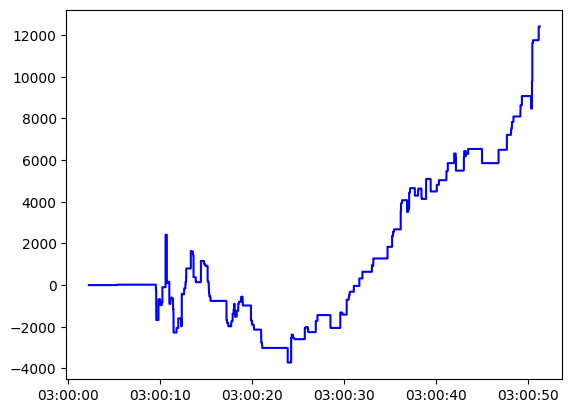

In [61]:
plt.plot(strategy.pnl_times, strategy.pnl_array, label="PnL", color="b")
plt.show()